
# Real Estate Market in the  East England

# Mette
## Movivation
**What is your dataset?**\
Our data consists of fourdatasets: 
* number of resales sold
* median price of the sold resalse
* number of primary houses sold
* median price of the sold primary houses

Each number of sold houses and median pirices are recorded each quater of the year from december 1995 to december 2015. 

The collection of the data is furthermore recorded for each area in east England: 
* Peterborough
* CambridgeEast 
* Cambridgeshire
* Fenland
* Huntingdonshire
* South Cambridgeshire
* Forest Heath
* St Edmundsbury

Furthermore we collected an aditional dataset in the form of geodata wich contains the gegraphical information on the districts above. This was nesessary in to visualize the areas on a map. 

**Why did you choose this/these particular dataset(s)?**\
We would like to help families move away from the city towards a more nature and kids frindly conuntry enviroment. In order to do so we envestigate the the area in East Englands property change over the years in the hopes of giving families a better overwiew where to invest. 
Should you buy a new build home or and existing one? What are your procerange for bying a house? How much will your property likely be worth in the furture? 
These four datasets plus the geodata made it possible to envestigate a small part of England while still getting nessecary details without it being to caotic and too much information that would be hard to navigate in. 

**What was your goal for the end user's experience?**\
To help families make the dicision moving to the contryside (east England). Provide them with enough knowledge that they would be able to make the right decision in regard to their move. This could depend on their house future value and how much money thay would have to put down right away for this envestment. 

## Basic Stats

### Libraries:

In [288]:
import matplotlib.pyplot as plt
import pandas as pd
import calendar
import calplot
import seaborn as sns
from scipy import stats
import numpy as np
import math
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import calplot
import json
import geopandas as gpd
import statistics

import folium
from folium.plugins import HeatMap
from folium.features import DivIcon
from ipywidgets import interact

from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import Category10_8
from bokeh.io import output_file
from bokeh.io import output_notebook

from bokeh.plotting import figure, show, output_file
from bokeh.models import ColorBar, ColumnDataSource, LinearColorMapper, NumeralTickFormatter, BasicTicker, Legend, LegendItem, PrintfTickFormatter
from bokeh.io import output_notebook
from bokeh.palettes import Category10, Greens 
from bokeh.transform import transform
from bokeh.layouts import row, column


from scipy import stats
import statistics
from statsmodels.api import OLS, add_constant

import plotly.offline as pyo
import mpld3

### Loading housing data:
https://data.cambridgeshireinsight.org.uk/dataset/house-sales-and-prices

In [289]:
df1 = pd.read_csv('../data/ons-existing-homes-count-corrected_0.csv')
df2 = pd.read_csv('../data/ons-existing-homes-median-price-corrected_0_0.csv')
df3 = pd.read_csv('../data/ons-new-build-count-corrected_0.csv')
df4 = pd.read_csv('../data/ons-new-build-median-price-corrected_0.csv')

### Loading geodata:
https://geoportal.statistics.gov.uk/datasets/7ceb69f99a024752b97ddac6b0323ab0_0/explore?location=52.328637%2C0.226945%2C8.77&showTable=true

In [290]:
# Loading geodata
gdf = gpd.read_file('../data/Local_Authority_Districts_December_2021_UK_BGC_2022_4923559779027843470.geojson')

# Areas
areas = ['Peterborough', 'Cambridge', 'East Cambridgeshire', 'Fenland', 'Huntingdonshire', 'South Cambridgeshire', 'West Suffolk']

# Areas that should be included
gdf_areas = gdf[gdf['LAD21NM'].isin(areas)]

### Preprossesing:

Since there are only data from december 1995 we remove all data from 2015 and therby only have data from 1996-2015

In [291]:
df1.drop(columns="Q4-1995", inplace=True)
df2.drop(columns="Q4-1995", inplace=True)
df3.drop(columns="Q4-1995", inplace=True)
df4.drop(columns="Q4-1995", inplace=True)

According to wikipedia: "St Edmundsbury and Forest Heath were merged on 1 April 2019 to form the new West Suffolk district"
https://en.wikipedia.org/wiki/Borough_of_St_Edmundsbury \
Therfore we merge the data for these two areas in order to compare over the years. 
We add the amount of houses sold in data 1 and 3 to find the total amount of sold houses in the combined district West Suffolk. We furthermore find the median of the median price in data 2 and 4 to get the median price in West Suffolk. 

In [292]:
# merge two districts
df1.iloc[6] = df1.iloc[6] + df1.iloc[7]
df3.iloc[6] = df3.iloc[5] + df3.iloc[6]
df2.iloc[6, 2:] = df2.iloc[6:8, 2:].median().round().astype(int)
df4.iloc[6, 2:] = df4.iloc[6:8, 2:].median().round().astype(int)

In [293]:
# creating same order for all data
df3.iloc[5]=df3.iloc[7]

# drop row 7
df1 = df1.drop(index=7)
df2 = df2.drop(index=7)
df3 = df3.drop(index=7)
df4 = df4.drop(index=7)

# rename the row and ONS code with the corresponding to West Suffolk
df1.loc[6, 'ONS code'] = 'E07000245'
df1.loc[6, 'Area'] = 'West Suffolk'

df2.loc[6, 'ONS code'] = 'E07000245'
df2.loc[6, 'Area'] = 'West Suffolk'

df3.loc[6, 'ONS code'] = 'E07000245'
df3.loc[6, 'Area'] = 'West Suffolk'

df4.loc[6, 'ONS code'] = 'E07000245'
df4.loc[6, 'Area'] = 'West Suffolk'

Reshaping data:

In [294]:
df1_flip = df1.melt(id_vars=['ONS code', 'Area'], var_name='Quarter', value_name='Houses Sold')
df2_flip = df2.melt(id_vars=['ONS code', 'Area'], var_name='Quarter', value_name='Price')
df3_flip = df3.melt(id_vars=['ONS code', 'Area'], var_name='Quarter', value_name='Houses Sold')
df4_flip = df4.melt(id_vars=['ONS code', 'Area'], var_name='Quarter', value_name='Price')

Extracting features:

In [295]:
# extract year and quarter
df1_flip[['Quarter', 'Year']] = df1_flip['Quarter'].str.split('-', expand=True)
df2_flip[['Quarter', 'Year']] = df2_flip['Quarter'].str.split('-', expand=True)
df3_flip[['Quarter', 'Year']] = df3_flip['Quarter'].str.split('-', expand=True)
df4_flip[['Quarter', 'Year']] = df4_flip['Quarter'].str.split('-', expand=True)

# convert Year to integer
df1_flip['Year'] = df1_flip['Year'].astype(int)
df2_flip['Year'] = df2_flip['Year'].astype(int)
df3_flip['Year'] = df3_flip['Year'].astype(int)
df4_flip['Year'] = df4_flip['Year'].astype(int)

In [296]:
# Sorting the data alphabetically
df1 = df1.sort_values('Area')
df2 = df2.sort_values('Area')
df3 = df3.sort_values('Area')
df4 = df4.sort_values('Area')

Quick show of data:

In [297]:
df1

,ONS code,Area,Q1-1996,Q2-1996,Q3-1996,Q4-1996,Q1-1997,Q2-1997,Q3-1997,Q4-1997,...,Q3-2013,Q4-2013,Q1-2014,Q2-2014,Q3-2014,Q4-2014,Q1-2015,Q2-2015,Q3-2015,Q4-2015
1,E07000008,Cambridge,1438,1458,1546,1718,1829,1979,2095,2102,...,1293,1320,1383,1412,1366,1378,1352,1327,1345,1310
2,E07000009,East Cambridgeshire,940,964,1014,1139,1172,1268,1362,1396,...,1166,1264,1337,1423,1462,1448,1428,1405,1308,1312
3,E07000010,Fenland,1214,1262,1296,1389,1491,1610,1763,1875,...,1379,1439,1562,1649,1684,1708,1617,1563,1597,1660
4,E07000011,Huntingdonshire,2575,2713,2910,3157,3347,3443,3485,3364,...,2419,2699,2926,3076,3328,3296,3182,3118,2975,2938
0,E06000031,Peterborough,2212,2194,2356,2530,2628,2808,2921,3022,...,1927,2021,2162,2218,2407,2460,2428,2423,2453,2488
5,E07000012,South Cambridgeshire,1773,1789,1928,2172,2280,2442,2563,2519,...,1986,2054,2195,2311,2380,2416,2351,2231,2133,2151
6,E07000245,West Suffolk,2104,2204,2393,2638,2751,2972,3133,3182,...,2431,2579,2731,2890,3022,3114,2982,2881,2842,2895


In [298]:
df1_flip

,ONS code,Area,Quarter,Houses Sold,Year
0,E06000031,Peterborough,Q1,2212,1996
1,E07000008,Cambridge,Q1,1438,1996
2,E07000009,East Cambridgeshire,Q1,940,1996
3,E07000010,Fenland,Q1,1214,1996
4,E07000011,Huntingdonshire,Q1,2575,1996
...,...,...,...,...,...
555,E07000009,East Cambridgeshire,Q4,1312,2015
556,E07000010,Fenland,Q4,1660,2015
557,E07000011,Huntingdonshire,Q4,2938,2015
558,E07000012,South Cambridgeshire,Q4,2151,2015


In [299]:
df2

,ONS code,Area,Q1-1996,Q2-1996,Q3-1996,Q4-1996,Q1-1997,Q2-1997,Q3-1997,Q4-1997,...,Q3-2013,Q4-2013,Q1-2014,Q2-2014,Q3-2014,Q4-2014,Q1-2015,Q2-2015,Q3-2015,Q4-2015
1,E07000008,Cambridge,69950,70000,72000,72500,73000,75000,78500,82500,...,290000,295000,295000,304075,315000,327350,337000,350000,370000,380000
2,E07000009,East Cambridgeshire,56500,57000,57000,57500,58000,58500,59000,60000,...,196011,195750,197000,200000,204050,215000,220000,226000,229950,240000
3,E07000010,Fenland,40000,40000,40000,40000,40000,41500,43000,44250,...,127000,130000,135000,137000,139995,140000,141000,145000,147500,150000
4,E07000011,Huntingdonshire,54000,54000,54625,54875,55000,56000,57000,58000,...,177000,178000,179995,184500,190000,195000,198000,200000,210000,215000
0,E06000031,Peterborough,40000,40000,40000,41000,41500,42000,43000,43500,...,125000,125000,129250,132750,135100,138000,140000,143500,145000,148000
5,E07000012,South Cambridgeshire,70000,70000,73125,74000,74000,75500,77500,79950,...,250000,250000,250000,250000,259875,266500,275000,284000,300000,315000
6,E07000245,West Suffolk,51250,50812,50988,51498,52000,53312,54750,55500,...,168000,170000,171750,175500,184000,189975,191750,197500,201374,205250


In [300]:
df2_flip

,ONS code,Area,Quarter,Price,Year
0,E06000031,Peterborough,Q1,40000,1996
1,E07000008,Cambridge,Q1,69950,1996
2,E07000009,East Cambridgeshire,Q1,56500,1996
3,E07000010,Fenland,Q1,40000,1996
4,E07000011,Huntingdonshire,Q1,54000,1996
...,...,...,...,...,...
555,E07000009,East Cambridgeshire,Q4,240000,2015
556,E07000010,Fenland,Q4,150000,2015
557,E07000011,Huntingdonshire,Q4,215000,2015
558,E07000012,South Cambridgeshire,Q4,315000,2015


### Exploratory data analysis:
After preprosessing the data we then have seven areas each with its corespondant ONS code
* Peterborough - E06000031
* Cambridge - E07000008	
* East Cambridgeshire - E07000009	
* Fenland - E07000010	
* Huntingdonshire - E07000011
* South Cambridgeshire - E07000012
* West Suffolk - E07000245

Each dataset consists of amount of houses sold or the median price for each area over a timespan from 1996-2015 for each quater in the year.

In [301]:
(2015-1996)*4

76

Leaving in total 76 rows with collected data for each area. 

To further envestigate the data we dive into some statistict for each dataset and area. We envestigate the maximum and minimum amount of houses sold and the meadian prices for each area.

#### Maximum and minimum amount of houses sold: 
##### Resale:

In [302]:
pd.concat([df1['Area'], 
           df1.iloc[:,2:].max(axis=1).rename('Max Houses sold'), 
           df1.iloc[:, 2:].idxmax(axis=1).rename('Q-Year'),
           df1.iloc[:,2:].min(axis=1).rename('Min Houes Sold'), 
           df1.iloc[:, 2:].idxmin(axis=1).rename('Q-Year')
          ], axis=1)

,Area,Max Houses sold,Q-Year,Min Houes Sold,Q-Year
1,Cambridge,2102,Q4-1997,971,Q2-2009
2,East Cambridgeshire,1894,Q3-2007,751,Q2-2009
3,Fenland,2659,Q3-2007,872,Q2-2009
4,Huntingdonshire,4407,Q2-2002,1617,Q2-2009
0,Peterborough,4625,Q3-2004,1311,Q2-2009
5,South Cambridgeshire,3016,Q2-2007,1245,Q2-2009
6,West Suffolk,3996,Q4-2006,1549,Q2-2009


##### Primary houses:

In [303]:
pd.concat([df3['Area'], 
           df3.iloc[:,2:].max(axis=1).rename('Max Houses sold'), 
           df3.iloc[:, 2:].idxmax(axis=1).rename('Q-Year'),
           df3.iloc[:,2:].min(axis=1).rename('Min Houses sold'), 
           df3.iloc[:, 2:].idxmin(axis=1).rename('Q-Year')
          ], axis=1)

,Area,Max Houses sold,Q-Year,Min Houses sold,Q-Year
1,Cambridge,724,Q1-2014,18,Q3-1999
2,East Cambridgeshire,567,Q1-2002,80,Q4-2015
3,Fenland,577,Q2-2003,64,Q4-2011
4,Huntingdonshire,765,Q1-2000,243,Q4-2008
0,Peterborough,781,Q1-2007,266,Q1-1996
5,South Cambridgeshire,713,Q1-2001,311,Q2-2005
6,West Suffolk,599,Q2-1997,239,Q4-2013


It is clear to see that in general in 2009 for the second quarter there weren't many resales in 2009 since this in the minimum for all areas. But also that there was a boost in resales around 2007. 
For the primary houses it looks as though the boost of houses sold lies around 2000-2003. However, each district had the smallest amount of primary houses sold spread out and nothing specific can be said from this. 

#### Maximum and minimum median prices: 
##### Resale:

In [304]:
pd.concat([df2['Area'], 
           df2.iloc[:,2:].max(axis=1).rename('Max Median Price'), 
           df2.iloc[:, 2:].idxmax(axis=1).rename('Q-Year'),
           df2.iloc[:,2:].min(axis=1).rename('Min Median Price'), 
           df2.iloc[:, 2:].idxmin(axis=1).rename('Q-Year')
          ], axis=1)

,Area,Max Median Price,Q-Year,Min Median Price,Q-Year
1,Cambridge,380000,Q4-2015,69950,Q1-1996
2,East Cambridgeshire,240000,Q4-2015,56500,Q1-1996
3,Fenland,150000,Q4-2015,40000,Q1-1996
4,Huntingdonshire,215000,Q4-2015,54000,Q1-1996
0,Peterborough,148000,Q4-2015,40000,Q1-1996
5,South Cambridgeshire,315000,Q4-2015,70000,Q1-1996
6,West Suffolk,205250,Q4-2015,50812,Q2-1996


##### Primary houses:

In [305]:
pd.concat([df4['Area'], 
           df4.iloc[:,2:].max(axis=1).rename('Max Median Price'), 
           df4.iloc[:, 2:].idxmax(axis=1).rename('Q-Year'),
           df4.iloc[:,2:].min(axis=1).rename('Min Median Price'), 
           df4.iloc[:, 2:].idxmin(axis=1).rename('Q-Year')
          ], axis=1)

,Area,Max Median Price,Q-Year,Min Median Price,Q-Year
1,Cambridge,499950,Q4-2015,90000,Q1-1996
2,East Cambridgeshire,237475,Q4-2015,64500,Q4-1996
3,Fenland,157250,Q3-2015,47950,Q1-1996
4,Huntingdonshire,225000,Q1-2014,83000,Q1-1996
0,Peterborough,193950,Q2-2008,50000,Q1-1996
5,South Cambridgeshire,345000,Q4-2015,105000,Q2-1996
6,West Suffolk,229495,Q4-2015,63349,Q1-1997


From these two datasets it is clear that the housing makrets prices have increased for both primary houses and resales over the years and only have gotten more expensive. They both have the cheepest prises in the year 1996 and the most expensive housing prices in 2015 leading us to beleave that the housing market only will get more expensive after 2015.

It is interesting that even though there weren't many resales in 2009 this isn't the year that the houses were most expensive. However, the general lower amount of resales sold in 2009 could have to do with something else like the economy. 

## Data Analysis and Visualizations

### Calender plot
Polar calendar by quarter with units sold
#### Amount of houses sold
##### Resale

In [306]:
# max and minimum values of the number of houses sold for both PRimary houses and resales (for the colorbar)
min_tot_sold = min([df1.values[:,2:].min(), df3.values[:,2:].min()])
max_tot_sold = max([df1.values[:,2:].max(), df3.values[:,2:].max()])

In [307]:
heatmap_trace = go.Heatmap(z=df1.values[:,2:][::-1],
                           x=df1.columns[2:],
                           y=df1.values[:,1][::-1],
                           colorscale='YlGn',
                           colorbar=dict()
                          )

layout = go.Layout(
    title={
        'text': 'Number of house sales over the years on the Resale Market',
        'x': 0.5,
        'xanchor': 'center'
    },
    xaxis=dict(title='Year and Quarter'),
    yaxis=dict(title='Area'), 
    width=1000, 
    height=300
)
fig = go.Figure(data=[heatmap_trace], layout=layout)
pyo.plot(fig, filename='../graphs/Heatmap_Resales_sold.html')

fig.show()

##### Primary houses

In [232]:
heatmap_trace = go.Heatmap(z=df3.values[:,2:][::-1],
                           x=df3.columns[2:],
                           y=df3.values[:,1][::-1],
                           colorscale='YlGn')

layout = go.Layout(title='',
                   xaxis=dict(title='Year and Quarter'),
                   yaxis=dict(title='Area'), 
                   width=1000, 
                   height=300)

layout = go.Layout(
    title={
        'text': 'Number of house sales over the years on the Primary Market',
        'x': 0.5,
        'xanchor': 'center'
    },
    xaxis=dict(title='Year and Quarter'),
    yaxis=dict(title='Area'), 
    width=1000, 
    height=300
)


fig = go.Figure(data=[heatmap_trace], layout=layout)

pyo.plot(fig, filename='../graphs/Heatmap_Primary_sold.html')

fig.show()

These two plots above helps to give a good visual indication of how many primary houses and resales that was sold over the years. It should be stated that the range of the colorbar is not the same for the two plots simply because it would be hard to distinguish between the areas for primary houses sold since they would all be in the lower end. 

It is very clear that when we look at the amount of resales sold there is a hunge peak around 2001-2008 followed by a significant drop which is probably the cause of the global financial crisis in 2008 (https://helmores.com/blog/a-history-lesson-how-the-uk-property-market-went-boom-amp-bust-in-2008/25549).

#### Median prices for homes
##### Median prices for resales

In [233]:
heatmap_trace = go.Heatmap(z=df2.values[:,2:][::-1],
                           x=df2.columns[2:],
                           y=df2.values[:,1][::-1],
                           colorscale='YlGn')

layout = go.Layout(title='Median Prices for Resales Over the Years for Each Area',
                   xaxis=dict(title='Year and Quarter'),
                   yaxis=dict(title='Area'), 
                   width=1000, 
                   height=300)

fig = go.Figure(data=[heatmap_trace], layout=layout)
pyo.plot(fig, filename='Heatmap_Resales_Price.html')

fig.show()

##### Median prices for primary houses

In [234]:
heatmap_trace = go.Heatmap(z=df4.values[:,2:][::-1],
                           x=df4.columns[2:],
                           y=df4.values[:,1][::-1],
                           colorscale='YlGn')

layout = go.Layout(title='Median prices for Primary Houses Sold Over the Years for Each Area',
                   xaxis=dict(title='Year and Quarter'),
                   yaxis=dict(title='Area'), 
                   width=1000, 
                   height=300)

fig = go.Figure(data=[heatmap_trace], layout=layout)
pyo.plot(fig, filename='Heatmap_Primary_Price.html')

fig.show()

Here we see that the prices increase for every year in every area both for resales but also for the primary market. This tendency is important to look deeper into since it can affect the amount of money a a family have to put down in order to buy a house. The increase in the prices make it harder for a family with an average income to be able to afford a house in Cambridge when comparing to Fernland. We will dive into this later.

### Folium map over the seven areas

For plotting areas over folium map\
https://geopandas.org/en/stable/gallery/polygon_plotting_with_folium.html

In [235]:
df = gdf_areas.to_crs(epsg=4326)
print(df.crs)
df

EPSG:4326


,OBJECTID,LAD21CD,LAD21NM,LAD21NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
28,29,E06000031,Peterborough,,517372,300777,-0.268740,52.59214,63a5f62f-6732-4abe-94c8-42d548fe9e7d,"POLYGON ((-0.05804 52.67407, -0.04494 52.66917..."
59,60,E07000008,Cambridge,,545420,257901,0.126436,52.20017,795c0c84-6340-447a-906b-c56b98398ac7,"POLYGON ((0.15525 52.23722, 0.16620 52.23424, ..."
60,61,E07000009,East Cambridgeshire,,555576,275765,0.283149,52.35788,31d476f0-46bd-4663-8c3d-c06afe7b4231,"MULTIPOLYGON (((0.24550 52.50054, 0.15507 52.4..."
61,62,E07000010,Fenland,,536361,294959,0.009016,52.53544,2fc9d242-6449-4f11-ad67-b62b9ba3dbec,"MULTIPOLYGON (((-0.11734 52.57778, -0.11972 52..."
62,63,E07000011,Huntingdonshire,,521008,274269,-0.224700,52.35315,fd31a6cd-cf71-4e3b-9518-e8fc5aee1968,"MULTIPOLYGON (((0.04706 52.35515, 0.04636 52.3..."
63,64,E07000012,South Cambridgeshire,,543295,247586,0.091017,52.10805,e6679d08-c024-40f6-97b2-95264933263e,"POLYGON ((0.03860 52.35324, 0.04320 52.35229, ..."
238,239,E07000245,West Suffolk,,580944,271124,0.652769,52.30842,f8b8d2e4-bb5c-499d-aaaa-b954dcc1eb4d,"POLYGON ((0.67476 52.45765, 0.67859 52.45460, ..."


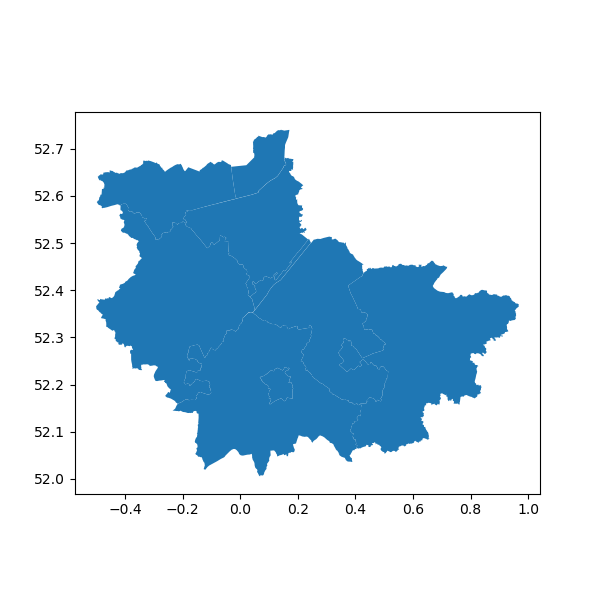

In [236]:
df.plot(figsize=(6, 6))
plt.show()

In [237]:
map_England = folium.Map(location=[52.3000, 0.1927], zoom_start=9, tiles="CartoDB positron")

In [238]:
for _, r in df.iterrows():
    sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"fillColor": "green", "color": "black", "weight": 1})
    folium.Popup(r["LAD21NM"]).add_to(geo_j)
    geo_j.add_to(map_England)


# adding names to the districts
for k in range(7):
    folium.map.Marker(
        [df['LAT'].iloc[k], df['LONG'].iloc[k]-0.05],
        icon=DivIcon(
            icon_size=(250,36),
            icon_anchor=(0,0),
            html='<div style="font-size: 13pt">{}</div>'.format(df['LAD21NM'].iloc[k]),
        )
    ).add_to(map_England)

map_England.save("../graphs/Map_East_England.html")

map_England

This plot shows the areas we are investigating and where they lie on a global map to make sure everyone who reads the webpage knows in which area we are talking about. 

### Heatmap
#### Heatmaps for number of houses sold in each area

In [239]:
# grouping by Area and summing up Houses Sold for each area across all years
Resale_Sold = df1_flip.groupby(['Area', 'Year'])['Houses Sold'].sum().reset_index()
Primary_Houses_Sold = df3_flip.groupby(['Area', 'Year'])['Houses Sold'].sum().reset_index()
Primary_Houses_Sold

,Area,Year,Houses Sold
0,Cambridge,1996,676
1,Cambridge,1997,885
2,Cambridge,1998,354
3,Cambridge,1999,150
4,Cambridge,2000,478
...,...,...,...
135,West Suffolk,2011,1325
136,West Suffolk,2012,1028
137,West Suffolk,2013,988
138,West Suffolk,2014,1292


##### Resales

In [240]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from ipywidgets import interact
vmin_sold = min([Resale_Sold['Houses Sold'].min(), Primary_Houses_Sold['Houses Sold'].min()])
vmax_sold = max([Resale_Sold['Houses Sold'].max(), Primary_Houses_Sold['Houses Sold'].max()])

def plot_houses_sold(year):
    gdf_areas_year = gdf_areas.merge(Resale_Sold[Resale_Sold['Year'] == year], left_on='LAD21NM', right_on='Area', how='left').fillna(0)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    gdf_areas_year.plot(column='Houses Sold', ax=ax, legend=True, cmap='BuGn', edgecolor='black', linewidth=0.5, vmin=vmin_sold, vmax=vmax_sold)
    for idx, row in gdf_areas_year.iterrows():
        plt.text(row.geometry.centroid.x, row.geometry.centroid.y, row['LAD21NM'], fontsize=8, horizontalalignment='center')
    
    plt.title(f'East England Areas sold Resales in {year}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    plt.show()

years = Resale_Sold['Year'].unique()
interact(plot_houses_sold, year=sorted(years))



interactive(children=(Dropdown(description='year', options=(1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 20…

<function __main__.plot_houses_sold(year)>

##### Primary houses

In [241]:
def plot_houses_sold(year):
    gdf_areas_year = gdf_areas.merge(Primary_Houses_Sold[Primary_Houses_Sold['Year'] == year], left_on='LAD21NM', right_on='Area')
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    gdf_areas_year.plot(column='Houses Sold', ax=ax, legend=True, cmap='BuGn', edgecolor='black', linewidth=0.5, vmin=vmin_sold, vmax=vmax_sold)
    for idx, row in gdf_areas_year.iterrows():
        plt.text(row.geometry.centroid.x, row.geometry.centroid.y, row['LAD21NM'], fontsize=8, horizontalalignment='center')
    
    plt.title(f'East England Areas Primary House Sold in {year}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    plt.show()
years = Primary_Houses_Sold['Year'].unique()

interact(plot_houses_sold, year=years)

interactive(children=(Dropdown(description='year', options=(1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 20…

<function __main__.plot_houses_sold(year)>

In order to compare the number of primary houses sold and the number of resales, the colorbar was adjusted to have the total minimum and the total maximum for the smallest and highest number. 

When doing this it is clear to see that there are sold a lot more of resales than there is primary houses. 

##### Plotting 4 years next to each other

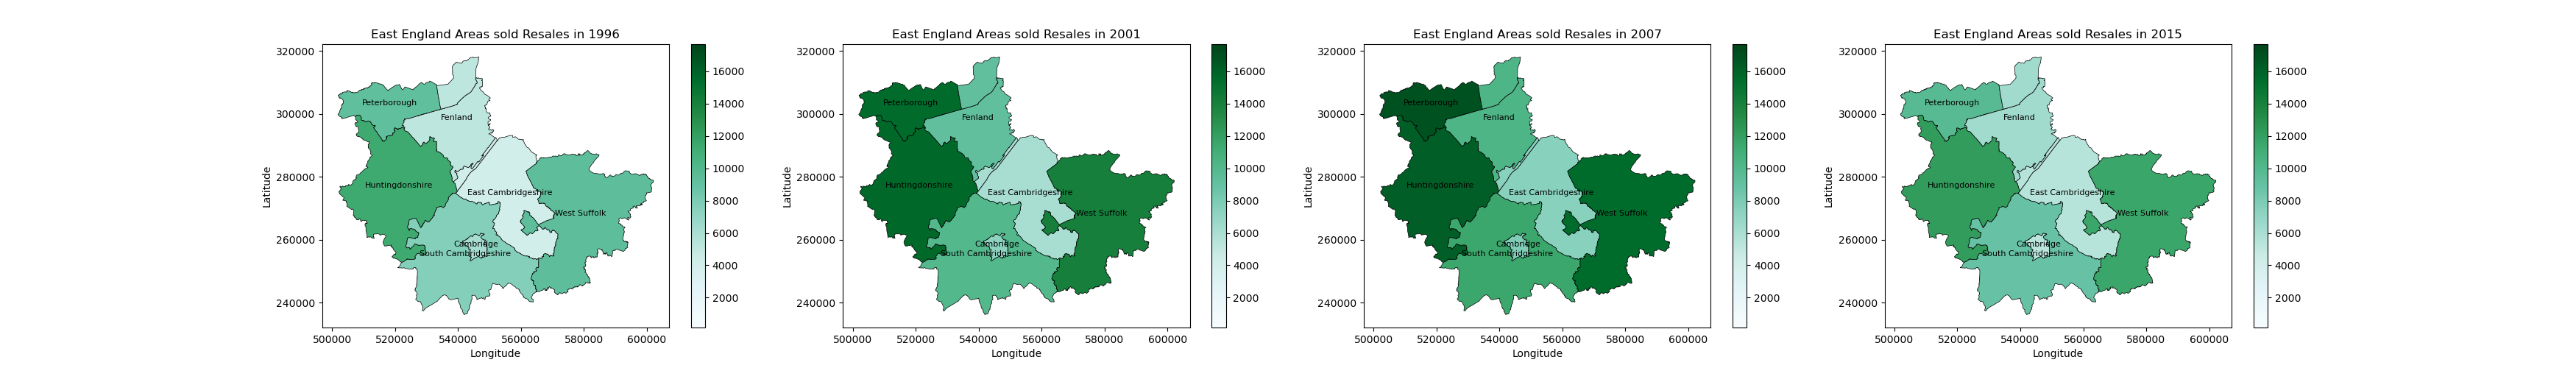

In [242]:

def plot_houses_sold(year, ax):
    gdf_areas_year = gdf_areas.merge(Resale_Sold[Resale_Sold['Year'] == year], left_on='LAD21NM', right_on='Area')
    
    gdf_areas_year.plot(column='Houses Sold', ax=ax, legend=True, cmap='BuGn', edgecolor='black', linewidth=0.5, vmin=vmin_sold, vmax=vmax_sold)
    
    for idx, row in gdf_areas_year.iterrows():
        ax.text(row.geometry.centroid.x, row.geometry.centroid.y, row['LAD21NM'], fontsize=8, horizontalalignment='center')
    
    ax.set_title(f'East England Areas sold Resales in {year}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

years = Resale_Sold['Year'].unique()

fig, axs = plt.subplots(1, 4, figsize=(35, 5))

for i, year in enumerate([1996, 2001, 2007, 2015]):
    plot_houses_sold(year, axs[i])

plt.savefig("Resales_price_4.png")


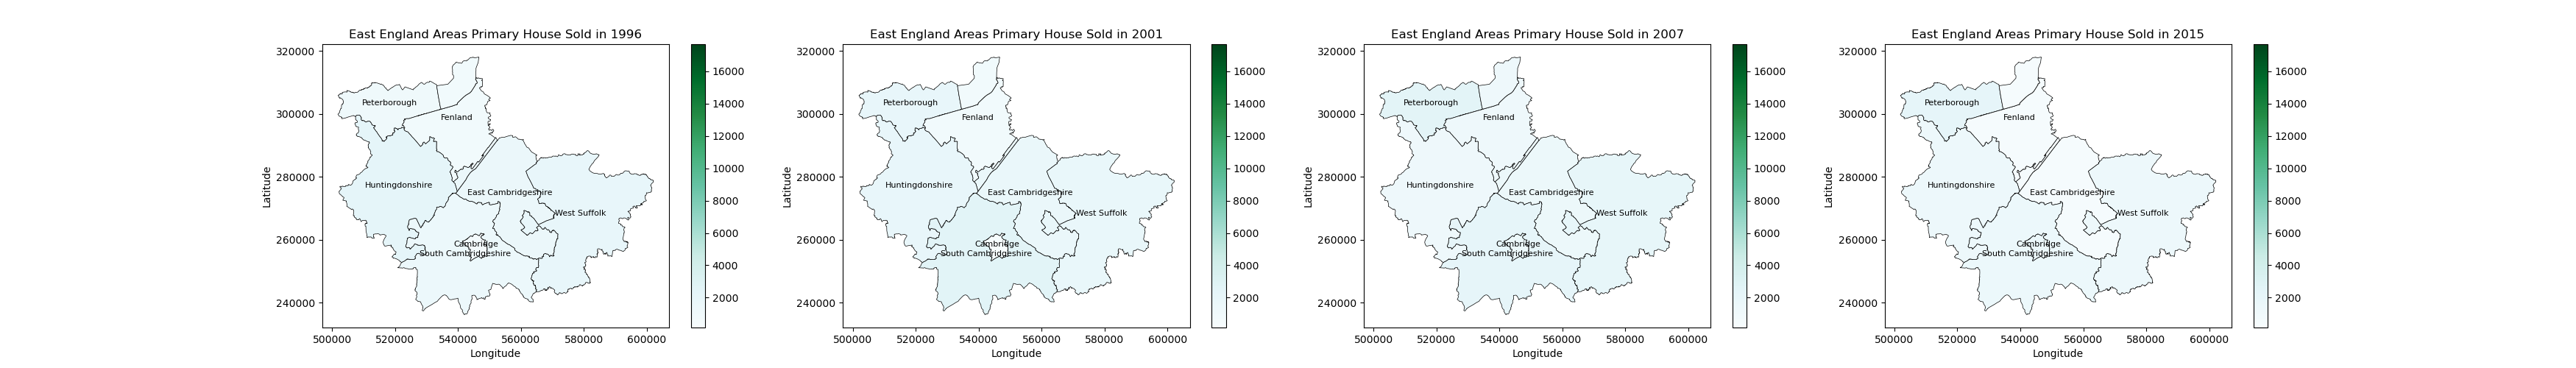

In [243]:
# Plotting resales in each specific year
def plot_houses_sold(year, ax):
    # Merge geodata with resales sold for that specific year
    gdf_areas_year = gdf_areas.merge(Primary_Houses_Sold[Primary_Houses_Sold['Year'] == year], left_on='LAD21NM', right_on='Area')
    
    gdf_areas_year.plot(column='Houses Sold', ax=ax, legend=True, cmap='BuGn', edgecolor='black', linewidth=0.5, vmin=vmin_sold, vmax=vmax_sold)
    
    # Labels for each area
    for idx, row in gdf_areas_year.iterrows():
        ax.text(row.geometry.centroid.x, row.geometry.centroid.y, row['LAD21NM'], fontsize=8, horizontalalignment='center')
    
    ax.set_title(f'East England Areas Primary House Sold in {year}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

# Year from DataFrame
years = Primary_Houses_Sold['Year'].unique()

# Plotting 4 years next to each other
fig, axs = plt.subplots(1, 4, figsize=(35, 5))

for i, year in enumerate([1996, 2001, 2007, 2015]):
    plot_houses_sold(year, axs[i])

plt.savefig("Primary_price_4.png")


#### Heatmaps for median prices for houses in each area

In [244]:
# Grouping by Area and taking the median of Price for each area across all years
Resale_Price = df2_flip.groupby(['Area', 'Year'])['Price'].median().round().astype(int).reset_index()
Primary_Houses_Price = df4_flip.groupby(['Area', 'Year'])['Price'].median().round().astype(int).reset_index()

Primary_Houses_Price

,Area,Year,Price
0,Cambridge,1996,93012
1,Cambridge,1997,107498
2,Cambridge,1998,143875
3,Cambridge,1999,142488
4,Cambridge,2000,121500
...,...,...,...
135,West Suffolk,2011,160862
136,West Suffolk,2012,188914
137,West Suffolk,2013,187874
138,West Suffolk,2014,184161


###### Resales

In [245]:
# For the colorbar we will have the max values for both resale en primary houses
vmin_price = min([Resale_Price['Price'].min(), Primary_Houses_Price['Price'].min()])
vmax_price = max([Resale_Price['Price'].max(), Primary_Houses_Price['Price'].max()])

# Plotting median price for resales in each specific year
def plot_houses_price(year):
    # Merge geodata with resales sold for that specific year
    gdf_areas_year = gdf_areas.merge(Resale_Price[Resale_Price['Year'] == year], left_on='LAD21NM', right_on='Area')
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    gdf_areas_year.plot(column='Price', ax=ax, legend=True, cmap='BuGn', edgecolor='black', linewidth=0.5, vmin=vmin_price, vmax=vmax_price)
    
    # Labels for each area
    for idx, row in gdf_areas_year.iterrows():
        plt.text(row.geometry.centroid.x, row.geometry.centroid.y, row['LAD21NM'], fontsize=8, horizontalalignment='center')
    
    plt.title(f'East England Areas Median Price for Resales in {year}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    plt.show()

# Year from DataFrame
years = Resale_Price['Year'].unique()

# Making the interactive plot
interact(plot_houses_price, year=years)

interactive(children=(Dropdown(description='year', options=(1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 20…

<function __main__.plot_houses_price(year)>

##### Primary houses

In [246]:
# Plotting median price for primary houses in each specific year
def plot_houses_price(year):
    # Merge geodata with resales sold for that specific year
    gdf_areas_year = gdf_areas.merge(Primary_Houses_Price[Primary_Houses_Price['Year'] == year], left_on='LAD21NM', right_on='Area')
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    gdf_areas_year.plot(column='Price', ax=ax, legend=True, cmap='BuGn', edgecolor='black', linewidth=0.5, vmin=vmin_price, vmax=vmax_price)
    
    # Labels for each area
    for idx, row in gdf_areas_year.iterrows():
        plt.text(row.geometry.centroid.x, row.geometry.centroid.y, row['LAD21NM'], fontsize=8, horizontalalignment='center')
    
    plt.title(f'East England Areas Median Price for Primary Houses in {year}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    plt.show()

# Year from DataFrame
years = Primary_Houses_Price['Year'].unique()

# Making the interactive plot
interact(plot_houses_price, year=years)

interactive(children=(Dropdown(description='year', options=(1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 20…

<function __main__.plot_houses_price(year)>

Heatmap showing the median price per year for both primary houses and resales. It can be seen that in the last years 2014 and 2015 the prises in Cambridge increased alot when visually comparring to the areas around them. 

When comparing to the two heatmaps above over the amount of houses sold. It is seen that the prices are increasing but the amount of houses sold is not - specifically for the Cambridge area where it is very obvious for 2015. 

# Nicola

In [247]:
# correlations for Existing Homes
existing_price_units_corr = df1.set_index('Area').drop(columns=['ONS code']).astype(float).corrwith(df2.set_index('Area').drop(columns=['ONS code']).astype(float))

# correlations for New Build Homes
new_build_price_units_corr = df3.set_index('Area').drop(columns=['ONS code']).astype(float).corrwith(df4.set_index('Area').drop(columns=['ONS code']).astype(float))

print("Correlation between existing homes' prices and units sold:")
print(existing_price_units_corr)

print("Correlation between new build homes' prices and units sold:")
print(new_build_price_units_corr)

Correlation between existing homes' prices and units sold:
Q1-1996   -0.151460
Q2-1996   -0.162706
Q3-1996   -0.136889
Q4-1996   -0.086813
Q1-1997   -0.083062
             ...   
Q4-2014   -0.338907
Q1-2015   -0.337691
Q2-2015   -0.367665
Q3-2015   -0.385340
Q4-2015   -0.423855
Length: 80, dtype: float64
Correlation between new build homes' prices and units sold:
Q1-1996    0.113298
Q2-1996    0.101025
Q3-1996    0.101748
Q4-1996    0.069398
Q1-1997    0.163882
             ...   
Q4-2014    0.468671
Q1-2015    0.425615
Q2-2015    0.375261
Q3-2015    0.172226
Q4-2015    0.037592
Length: 80, dtype: float64


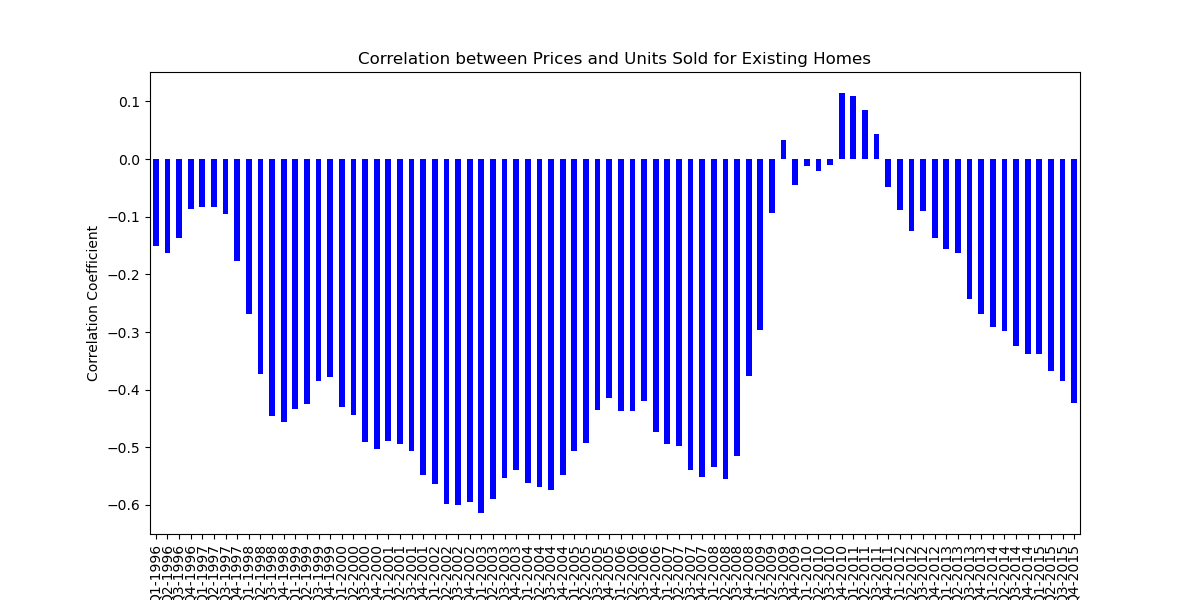

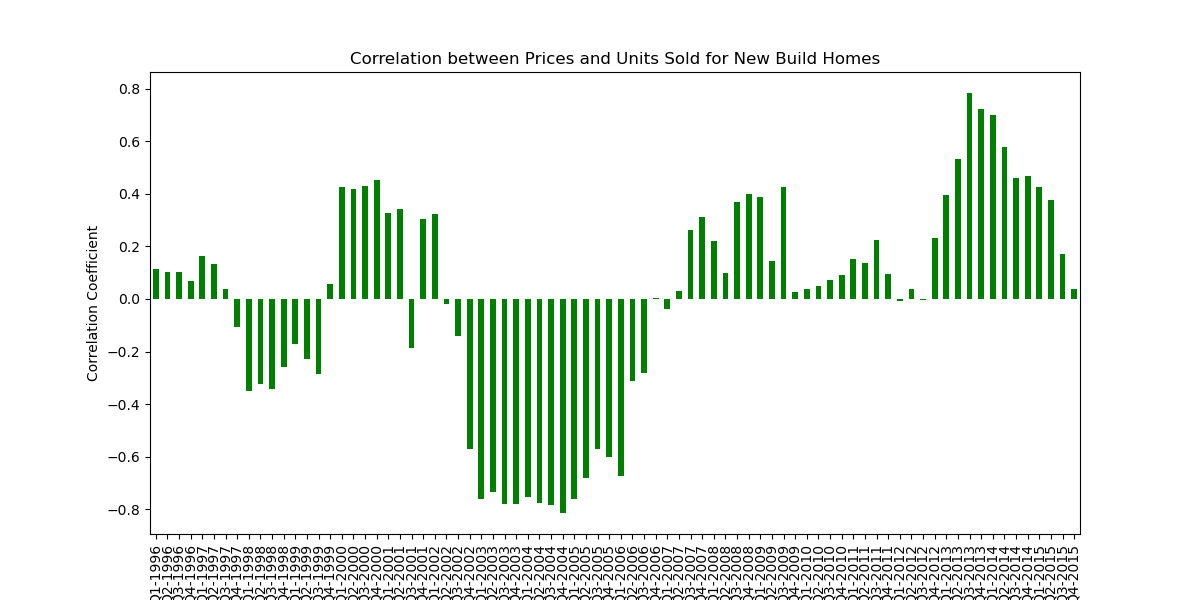

In [248]:
plt.figure(figsize=(12, 6))
existing_price_units_corr.plot(kind='bar', color='blue')
plt.title('Correlation between Prices and Units Sold for Existing Homes')
plt.xlabel('Quarter')
plt.ylabel('Correlation Coefficient')
plt.show()

plt.figure(figsize=(12, 6))
new_build_price_units_corr.plot(kind='bar', color='green')
plt.title('Correlation between Prices and Units Sold for New Build Homes')
plt.xlabel('Quarter')
plt.ylabel('Correlation Coefficient')
plt.show()

EXISTING: There is a generally negative correlation throughout most of the period, suggesting that higher prices tend to be associated with fewer units sold. This might indicate price sensitivity in the existing homes market.
The correlation appears to become less negative over time, especially around 2008-2010, which could coincide with market adjustments or economic events like the financial crisis, potentially altering buying behavior.
After 2010, the correlation becomes more negative again before stabilizing towards the end, suggesting a return to the earlier trend.

NEW HOUSES: The correlation for new build homes also starts negative but shows significant variability over time.
Notably, there is a period where the correlation turns positive around 2004 to 2008, indicating that during this time, higher prices did not deter buyers of new build homes, possibly due to a booming real estate market or attractiveness of newer properties.
The correlation dips again into the negative after 2008, likely influenced by the broader economic downturn, which may have made new build homes less attractive or attainable.
A significant rise in positive correlation from around 2010 through 2015 suggests a strong recovery in the new build market where higher prices coincide with higher sales.

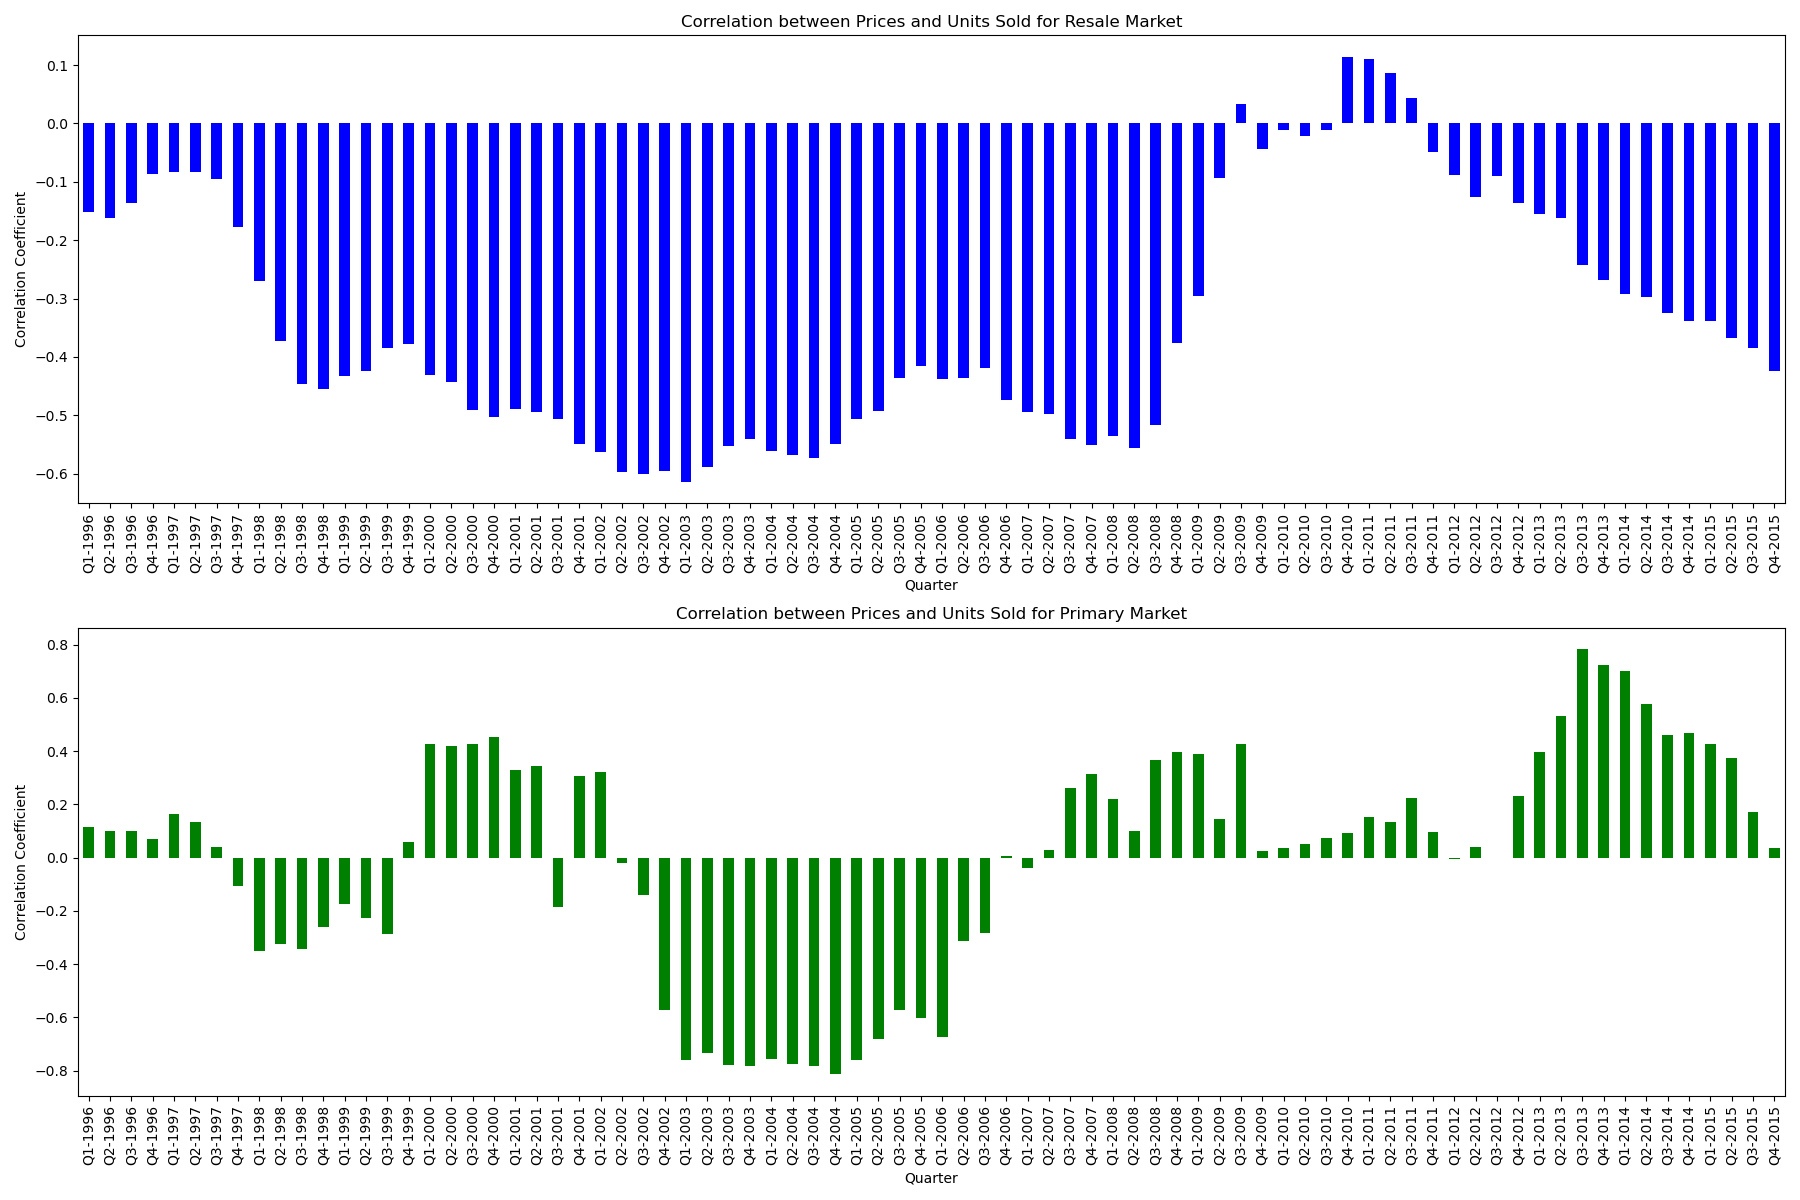

In [249]:
# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(18, 12))

# Plot existing homes correlation
existing_price_units_corr.plot(kind='bar', color='blue', ax=axs[0])
axs[0].set_title('Correlation between Prices and Units Sold for Resale Market')
axs[0].set_xlabel('Quarter')
axs[0].set_ylabel('Correlation Coefficient')

# Plot new build homes correlation
new_build_price_units_corr.plot(kind='bar', color='green', ax=axs[1])
axs[1].set_title('Correlation between Prices and Units Sold for Primary Market')
axs[1].set_xlabel('Quarter')
axs[1].set_ylabel('Correlation Coefficient')

# Adjust layout
plt.tight_layout()

# Convert the Matplotlib figure to Plotly figure
fig = go.Figure()
for ax in axs:
    fig.add_trace(go.Bar(x=ax.get_xticks(), y=ax.get_yticks(), marker_color='rgba(0,0,0,0)'))

# Save the figure as HTML
fig.write_html('../graphs/correlation_1.html')

# Show the plot
plt.show()

In [250]:
fig = make_subplots(rows=2, cols=1, subplot_titles=('Correlation between Prices and Units Sold for the Resale Market', 'Correlation between Prices and Units Sold for the Primary Market'))

fig.add_trace(
    go.Bar(x=existing_price_units_corr.index, y=existing_price_units_corr.values, name='Resale Market', marker_color='blue'),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=new_build_price_units_corr.index, y=new_build_price_units_corr.values, name='Primary Market', marker_color='green'),
    row=2, col=1
)

fig.update_xaxes(title_text="Quarter", row=1, col=1)
fig.update_xaxes(title_text="Quarter", row=2, col=1)

fig.update_yaxes(title_text="Correlation Coefficient", row=1, col=1)
fig.update_yaxes(title_text="Correlation Coefficient", row=2, col=1)

fig.update_layout(height=800, width=1000, showlegend=False)
fig.layout.margin.update({'t': 50, 'l': 20})

fig.show()
fig.write_html('../graphs/correlation 2.html')

In [256]:
areas = df1['Area'].tolist()
existing_corr_data = existing_price_units_corr.tolist()
new_build_corr_data = new_build_price_units_corr.tolist()

# create a ColumnDataSource
source = ColumnDataSource(data=dict(areas=areas, existing=existing_corr_data, new_build=new_build_corr_data))

output_file('../graphs/correlation_3_units_and_prices.html')

p = figure(x_range=areas, title="Correlation between Prices and Units Sold", toolbar_location=None, tools="", height=600, width=800)

p.title.align = 'center'
r1 = p.vbar(x='areas', top='existing', width=0.4, source=source, color='blue', legend_label="Resale Market", alpha=0.75)
r2 = p.vbar(x='areas', top='new_build', width=0.4, source=source, color='green', legend_label="Primary Market", alpha=0.75)

p.xgrid.grid_line_color = None
p.y_range.start = -1
p.y_range.end = 1
p.xaxis.major_label_orientation = 1.57

legend = Legend(items=[
    LegendItem(label='Existing Homes', renderers=[r1], index=0),
    LegendItem(label='New Build Homes', renderers=[r2], index=0)
])

p.legend.location = "top"
p.legend.click_policy="hide"

# Show the plot
show(p)

/var/folders/p5/8kc_v4413nsdcn4002zvhcv80000gn/T/ipykernel_65506/829020634.py:7: BokehUserWarning:

ColumnDataSource's columns must be of the same length. Current lengths: ('areas', 7), ('existing', 80), ('new_build', 80)



The correlations are mostly negative across both home types in most districts, reinforcing the general trend that higher prices might be limiting sales.
Some districts show a mix of negative and slightly positive correlations for new build homes, indicating localized variations in how price affects sales. These variations could be driven by factors like local economic conditions, availability of housing, and consumer preferences.
Notably, in West Suffolk, new build homes show a positive correlation, suggesting that in this area, higher prices might correlate with increased demand or a perception of higher value in new homes.
- Price Sensitivity: Existing homes show consistent price sensitivity, with higher prices generally correlating with fewer sales. This could suggest a more established market where buyers are cautious about pricing.
- Market Dynamics: New build homes show more variability, indicating that this market may be influenced by different factors, including economic cycles, the appeal of new features, and potentially more aggressive marketing strategies.

In [257]:
# merge the dfs 
df1_melted = df1.melt(id_vars=["ONS code", "Area"], var_name="Quarter", value_name="Units_Sold")
df2_melted = df2.melt(id_vars=["ONS code", "Area"], var_name="Quarter", value_name="Median_Price")

df3_melted = df3.melt(id_vars=["ONS code", "Area"], var_name="Quarter", value_name="Units_Sold")
df4_melted = df4.melt(id_vars=["ONS code", "Area"], var_name="Quarter", value_name="Median_Price")

# merge datasets
existing_homes = pd.merge(df1_melted, df2_melted, on=["ONS code", "Area", "Quarter"])
new_build_homes = pd.merge(df3_melted, df4_melted, on=["ONS code", "Area", "Quarter"])

# calculate the price to units sold ratio
existing_homes['Price_to_Units_Ratio'] = existing_homes['Median_Price'] / existing_homes['Units_Sold']
new_build_homes['Price_to_Units_Ratio'] = new_build_homes['Median_Price'] / new_build_homes['Units_Sold']


In [260]:
fig = make_subplots(rows=2, cols=1, subplot_titles=('Resale Market', 'Primary Market'))

fig.add_trace(go.Scatter(x=existing_homes['Quarter'], y=existing_homes['Price_to_Units_Ratio'], mode='lines', name='Resale Market'), row=1, col=1)

fig.add_trace(go.Scatter(x=new_build_homes['Quarter'], y=new_build_homes['Price_to_Units_Ratio'], mode='lines', name='Primary Market', line=dict(color='green')), row=2, col=1)

fig.update_xaxes(title_text='Quarter', row=1, col=1)
fig.update_xaxes(title_text='Quarter', row=2, col=1)
fig.update_yaxes(title_text='Price to Units Sold Ratio', row=1, col=1)
fig.update_yaxes(title_text='Price to Units Sold Ratio', row=2, col=1)

fig.update_layout(title_text='Time Series of Price to Units Sold Ratio', height=800, width=1000)

fig.show()
fig.write_html('../graphs/correlation .html')

In [287]:
# Bubble chart for existing homes
fig5 = px.scatter(existing_homes, x='Quarter', y='Price_to_Units_Ratio', size='Units_Sold', color='Area',
                  title='Resale Market: Price to Units Sold Ratio with Volume of Sales',
                  labels={'Price_to_Units_Ratio': 'Price/Unit Ratio', 'Units_Sold': 'Volume of Sales'})

fig5.update_layout(title_x=0.5) 
fig5.show()

# Bubble chart for new build homes
fig6 = px.scatter(new_build_homes, x='Quarter', y='Price_to_Units_Ratio', size='Units_Sold', color='Area',
                  title='Primary Market: Price to Units Sold Ratio with Volume of Sales',
                  labels={'Price_to_Units_Ratio': 'Price/Unit Ratio', 'Units_Sold': 'Volume of Sales'})

fig6.update_layout(title_x=0.5)
fig6.update_yaxes(range=[0, 6000])

fig6.show()

fig5.write_html('../graphs/Existing Homes Volume of Sales.html')
fig6.write_html('../graphs/New Build Homes Volume of Sales.html')

In [264]:
def prepare_data(df):
    # Convert 'Quarter' into two columns 'Year' and 'Quarter' and calculate a numeric time feature
    df['Year'] = df['Quarter'].apply(lambda x: int(x.split('-')[1]))
    df['Quarter_Num'] = df['Quarter'].apply(lambda x: (x.split('-')[0][1]))
    df['Time_Index'] = (df['Year'] - 1996) * 4 + df['Quarter_Num'].astype(int) - 1

    return df

existing_prepared = prepare_data(existing_homes)
new_prepared = prepare_data(new_build_homes)

In [265]:
existing_prepared.head()

,ONS code,Area,Quarter,Units_Sold,Median_Price,Price_to_Units_Ratio,Year,Quarter_Num,Time_Index
0,E07000008,Cambridge,Q1-1996,1438,69950,48.643950,1996,1,0
1,E07000009,East Cambridgeshire,Q1-1996,940,56500,60.106383,1996,1,0
2,E07000010,Fenland,Q1-1996,1214,40000,32.948929,1996,1,0
3,E07000011,Huntingdonshire,Q1-1996,2575,54000,20.970874,1996,1,0
4,E06000031,Peterborough,Q1-1996,2212,40000,18.083183,1996,1,0


In [266]:
non_numeric_columns = new_prepared.select_dtypes(exclude=[np.number]).columns

# Drop non-numeric columns
data_numeric = new_prepared.drop(columns=[*non_numeric_columns, "Time_Index"])

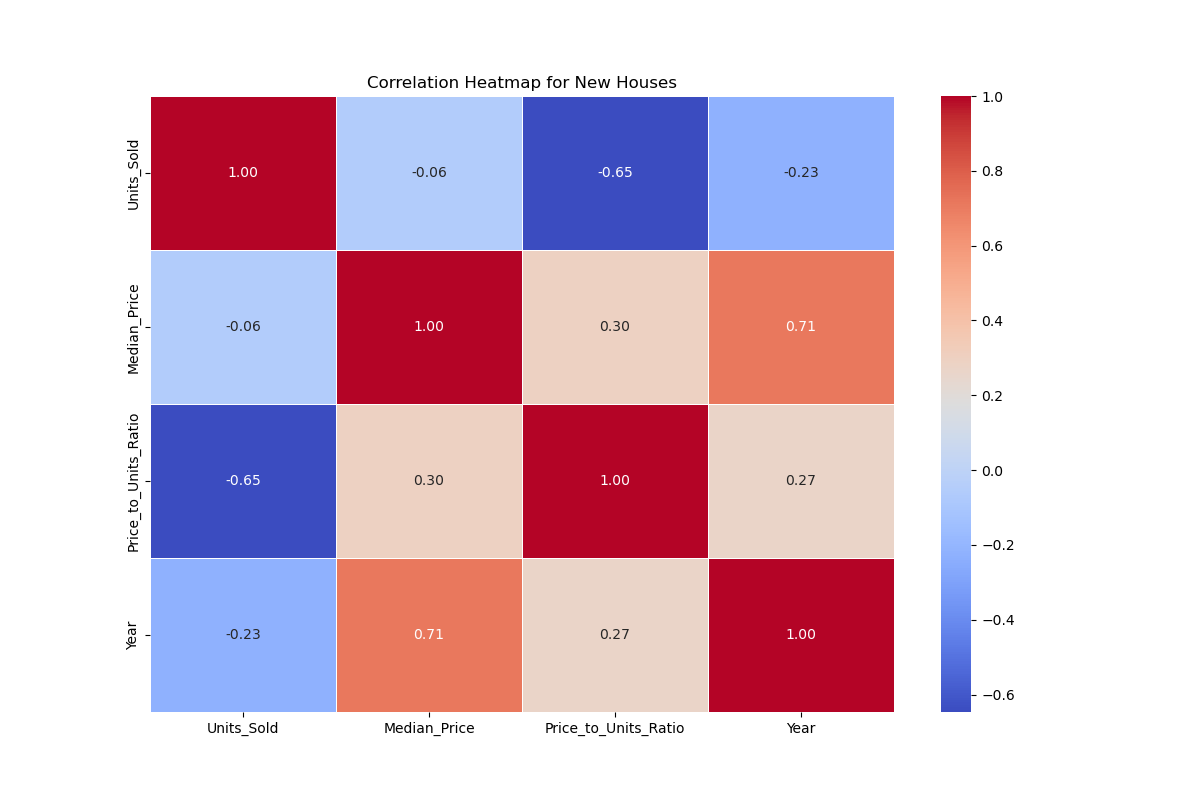

In [267]:
#includes non numeric columns
correlation_matrix = data_numeric.corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap for New Houses")
plt.show()

- Units Sold and Median Price: The correlation is moderately negative (-0.32), suggesting a stronger inverse relationship compared to new homes. This could indicate that higher prices more notably affect the volume of units sold in the existing homes market.
- Median Price and Price to Units Ratio: There is a very strong positive correlation (0.83), indicating that increases in median prices strongly affect the price to units ratio. As prices increase, the ratio of price per unit sold also increases significantly.
- Price to Units Ratio and Units Sold: This shows a strong negative correlation (-0.67), indicating that as the price per unit increases, the number of units sold tends to decrease significantly.
- Year and Other Variables: Year shows significant positive correlations with median price (0.77) and price to units ratio (0.65), suggesting that over time, both the median prices and the price per unit sold have increased. The year has a smaller negative correlation with units sold (-0.28), suggesting a potential gradual decrease in the number of units sold over time.

# Aleksandra
### Price trends for all districts over the years
Below is an analysis of apartment prices on the primary and secondary markets for subsequent districts. In order to best compare prices and their changes between districts, charts were created for each district and then superimposed on one chart. Additionally, we used linear regression to check the average annual change for each district, which allowed us to predict the dynamics of changes in subsequent years.

#### PRIMARY MARKET
#### - for each quarter

In [268]:
# combine data frames df1 and df2 for resale market
df_resale_market = pd.merge(df1_flip, df2_flip[['ONS code', 'Area', 'Quarter', 'Year', 'Price']],
                          on=['ONS code', 'Area', 'Quarter', 'Year'], how='left')

In [269]:
# combine data frames df3 and df4 for primary market
df_primary_market = pd.merge(df3_flip, df4_flip[['ONS code', 'Area', 'Quarter', 'Year', 'Price']],
                          on=['ONS code', 'Area', 'Quarter', 'Year'], how='left')

In [270]:
df_primary_market['Year_Quarter'] = df_primary_market['Year'].astype(str) + ' ' + df_primary_market['Quarter']
df_primary_market.sort_values(by='Year_Quarter', inplace=True)

areas = df_primary_market['Area'].unique()


for area in areas:
    area_data = df_primary_market[df_primary_market['Area'] == area]
    
    # Extract only the year part from 'Year_Quarter' for ticks
    labels = area_data['Year_Quarter'].tolist()
    year_ticks = [label for index, label in enumerate(labels) if index % 4 == 0] 
    fig = px.line(area_data, x='Year_Quarter', y='Price', 
                  title=f'Price Trend for {area}', 
                  labels={'Year_Quarter': 'Year and Quarter', 'Price': 'Price'},
                  markers=True,
                  color_discrete_sequence=['green']) 

    fig.update_xaxes(tickvals=[labels.index(tick) for tick in year_ticks], ticktext=[tick.split()[0] for tick in year_ticks])
    
    fig.update_layout(
        xaxis_title='Year and Quarter',
        yaxis_title='Price',
        xaxis=dict(tickangle=45),
        template='plotly_white',
        autosize=True
    )
    
    fig.show()

In [271]:
# For each area, fit a linear regression model and forecast prices
for area in areas:
    area_data = df_primary_market[df_primary_market['Area'] == area]

    # Prepare data for regression
    area_data['Year_Index'] = area_data['Year'].astype(int) - area_data['Year'].astype(int).min()
    X = add_constant(area_data['Year_Index'])  # Adds a constant term to the predictor
    y = area_data['Price']

    # Fit the regression model
    model = OLS(y, X).fit()
    
    # Print summary of regression
    print(f"Regression summary for {area}:\n", model.summary())

    # forecast for the next 5 years
    forecast_years = pd.DataFrame({'Year_Index': range(area_data['Year_Index'].max() + 1, area_data['Year_Index'].max() + 6)})
    forecast_years = add_constant(forecast_years)  # Add the constant term
    predictions = model.predict(forecast_years)

    # create a DataFrame for plotting forecasted values
    forecasted_data = pd.DataFrame({
        'Year_Quarter': [str(year) + ' Q1' for year in range(area_data['Year'].max() + 1, area_data['Year'].max() + 6)],
        'Price': predictions
    })

    # combine historical and forecasted data
    combined_data = pd.concat([area_data, forecasted_data])

    # Plotting with Plotly
    fig = px.line(combined_data, x='Year_Quarter', y='Price', 
                  title=f'Price Trend and Forecast for {area}', 
                  labels={'Year_Quarter': 'Year and Quarter', 'Price': 'Price'},
                  markers=True,
                  color_discrete_sequence=['green'])

    fig.update_layout(
        xaxis_title='Year and Quarter',
        yaxis_title='Price',
        xaxis=dict(tickangle=45),
        template='plotly_white',
        autosize=True
    )

    fig.show()


Regression summary for Peterborough:
                             OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     263.8
Date:                Tue, 07 May 2024   Prob (F-statistic):           9.63e-27
Time:                        23:12:07   Log-Likelihood:                -907.10
No. Observations:                  80   AIC:                             1818.
Df Residuals:                      78   BIC:                             1823.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.

/var/folders/p5/8kc_v4413nsdcn4002zvhcv80000gn/T/ipykernel_65506/3374400604.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Regression summary for Cambridge:
                             OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     263.7
Date:                Tue, 07 May 2024   Prob (F-statistic):           9.77e-27
Time:                        23:12:07   Log-Likelihood:                -969.51
No. Observations:                  80   AIC:                             1943.
Df Residuals:                      78   BIC:                             1948.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.313

/var/folders/p5/8kc_v4413nsdcn4002zvhcv80000gn/T/ipykernel_65506/3374400604.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Regression summary for East Cambridgeshire:
                             OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     288.3
Date:                Tue, 07 May 2024   Prob (F-statistic):           6.42e-28
Time:                        23:12:07   Log-Likelihood:                -915.26
No. Observations:                  80   AIC:                             1835.
Df Residuals:                      78   BIC:                             1839.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const  

/var/folders/p5/8kc_v4413nsdcn4002zvhcv80000gn/T/ipykernel_65506/3374400604.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Regression summary for Fenland:
                             OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     275.6
Date:                Tue, 07 May 2024   Prob (F-statistic):           2.54e-27
Time:                        23:12:07   Log-Likelihood:                -894.68
No. Observations:                  80   AIC:                             1793.
Df Residuals:                      78   BIC:                             1798.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        5.94e+

/var/folders/p5/8kc_v4413nsdcn4002zvhcv80000gn/T/ipykernel_65506/3374400604.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Regression summary for Huntingdonshire:
                             OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     288.8
Date:                Tue, 07 May 2024   Prob (F-statistic):           6.05e-28
Time:                        23:12:07   Log-Likelihood:                -904.65
No. Observations:                  80   AIC:                             1813.
Df Residuals:                      78   BIC:                             1818.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

/var/folders/p5/8kc_v4413nsdcn4002zvhcv80000gn/T/ipykernel_65506/3374400604.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Regression summary for South Cambridgeshire:
                             OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     421.8
Date:                Tue, 07 May 2024   Prob (F-statistic):           3.38e-33
Time:                        23:12:08   Log-Likelihood:                -912.75
No. Observations:                  80   AIC:                             1830.
Df Residuals:                      78   BIC:                             1834.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

/var/folders/p5/8kc_v4413nsdcn4002zvhcv80000gn/T/ipykernel_65506/3374400604.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Regression summary for West Suffolk:
                             OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     332.5
Date:                Tue, 07 May 2024   Prob (F-statistic):           7.42e-30
Time:                        23:12:08   Log-Likelihood:                -905.86
No. Observations:                  80   AIC:                             1816.
Df Residuals:                      78   BIC:                             1820.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.

/var/folders/p5/8kc_v4413nsdcn4002zvhcv80000gn/T/ipykernel_65506/3374400604.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### - average for each year

In [272]:
df_primary_market['Year'] = df_primary_market['Year_Quarter'].str.split().str[0]

# group by 'Year' and 'Area' to calculate average price per year per area
yearly_avg = df_primary_market.groupby(['Year', 'Area']).agg({'Price': 'mean'}).reset_index()
areas = yearly_avg['Area'].unique()

n_rows = 2
n_cols = 4
fig = make_subplots(rows=n_rows, cols=n_cols, subplot_titles=areas)


plot_row, plot_col = 1, 1

# uniform Y-axis range based on max and min of average prices

max_price = yearly_avg['Price'].max()
min_price = yearly_avg['Price'].min()

for i, area in enumerate(areas, start=1):
    area_data = yearly_avg[yearly_avg['Area'] == area]
    trace = go.Scatter(x=area_data['Year'], y=area_data['Price'], 
                       mode='lines+markers', name=area, 
                       line=dict(color='green'))
    
    fig.add_trace(trace, row=plot_row, col=plot_col)
    
    plot_col += 1
    if plot_col > n_cols: 
        plot_row += 1
        plot_col = 1
    if plot_row > n_rows and plot_col > n_cols:
        break

fig.update_yaxes(range=[min_price, max_price], nticks=10)

fig.update_layout(height=800, width=1200, title_text="Yearly Average Price Trends by District",
                  showlegend=False, template='plotly_white', title_x=0.5)

fig.show()

#Saving to HTML
fig.write_html('../graphs/full_figure.html')


To have a general picture of prices and their changes over the years, price trends for all districts are presented. In the case of the 'Cambridge' district, price changes are the most rapid, and the smallest differences can be observed in the case of the 'Fenland' district.

In [274]:
df_primary_market['Year'] = df_primary_market['Year_Quarter'].str.split().str[0]
yearly_avg = df_primary_market.groupby(['Year', 'Area']).agg({'Price': 'mean'}).reset_index()
areas = yearly_avg['Area'].unique()

output_notebook() 
output_file("../graphs/district_price_trends_primary_market.html") 

p = figure(title="Yearly Average Price Trends by District on the Primary Market", x_axis_label='Year', y_axis_label='Price',
           tools="pan,wheel_zoom,box_zoom,reset,save", width=1000, height=400)

p.title.align = 'center' 
colors = Category10[10] 

legend_items = []

for i, area in enumerate(areas):
    color = colors[i % len(colors)] 
    area_data = yearly_avg[yearly_avg['Area'] == area]
    source = ColumnDataSource(area_data)
    line = p.line(x='Year', y='Price', line_width=2, color=color, source=source)
    
    circle = p.circle(x='Year', y='Price', fill_color=color, line_color=color, size=8, source=source)

    legend_items.append(LegendItem(label=area, renderers=[line, circle]))

p.yaxis.formatter = NumeralTickFormatter(format="0a") 

custom_legend = Legend(items=legend_items, location="top_left")
p.add_layout(custom_legend, 'right')
p.legend.click_policy="hide" 

show(p) 


Loading BokehJS ...

#### RESALE MARKET 

In [275]:
df_resale_market['Year_Quarter'] = df_resale_market['Year'].astype(str) + ' ' + df_resale_market['Quarter']
df_resale_market.sort_values(by='Year_Quarter', inplace=True)

areas = df_resale_market['Area'].unique()


for area in areas:
    area_data = df_primary_market[df_primary_market['Area'] == area]
    
    # extract only the year part from 'Year_Quarter' for ticks
    labels = area_data['Year_Quarter'].tolist()
    year_ticks = [label for index, label in enumerate(labels) if index % 4 == 0] 
    fig = px.line(area_data, x='Year_Quarter', y='Price', 
                  title=f'Price Trend for {area}', 
                  labels={'Year_Quarter': 'Year and Quarter', 'Price': 'Price'},
                  markers=True,
                  color_discrete_sequence=['green']) 

    fig.update_xaxes(tickvals=[labels.index(tick) for tick in year_ticks], ticktext=[tick.split()[0] for tick in year_ticks])
    
    fig.update_layout(
        xaxis_title='Year and Quarter',
        yaxis_title='Price',
        xaxis=dict(tickangle=45),
        template='plotly_white',
        autosize=True
    )
    
    fig.show()

In [276]:
# for each area, fit a linear regression model and forecast prices
for area in areas:
    area_data = df_resale_market[df_resale_market['Area'] == area]

    # prepare data for regression
    area_data['Year_Index'] = area_data['Year'].astype(int) - area_data['Year'].astype(int).min()
    X = add_constant(area_data['Year_Index']) 
    y = area_data['Price']

    # fit the regression model
    model = OLS(y, X).fit()
    print(f"Regression summary for {area}:\n", model.summary())

    # forecast for the next 5 years
    forecast_years = pd.DataFrame({'Year_Index': range(area_data['Year_Index'].max() + 1, area_data['Year_Index'].max() + 6)})
    forecast_years = add_constant(forecast_years) 
    predictions = model.predict(forecast_years)

    # create a DataFrame for plotting forecasted values
    forecasted_data = pd.DataFrame({
        'Year_Quarter': [str(year) + ' Q1' for year in range(area_data['Year'].max() + 1, area_data['Year'].max() + 6)],
        'Price': predictions
    })

    # combine historical and forecasted data
    combined_data = pd.concat([area_data, forecasted_data])

    fig = px.line(combined_data, x='Year_Quarter', y='Price', 
                  title=f'Price Trend and Forecast for {area}', 
                  labels={'Year_Quarter': 'Year and Quarter', 'Price': 'Price'},
                  markers=True,
                  color_discrete_sequence=['green'])

    fig.update_layout(
        xaxis_title='Year and Quarter',
        yaxis_title='Price',
        xaxis=dict(tickangle=45),
        template='plotly_white',
        autosize=True
    )

    fig.show()


Regression summary for Peterborough:
                             OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     419.2
Date:                Tue, 07 May 2024   Prob (F-statistic):           4.16e-33
Time:                        23:13:45   Log-Likelihood:                -881.94
No. Observations:                  80   AIC:                             1768.
Df Residuals:                      78   BIC:                             1773.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.

/var/folders/p5/8kc_v4413nsdcn4002zvhcv80000gn/T/ipykernel_65506/1189949469.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Regression summary for Cambridge:
                             OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     2083.
Date:                Tue, 07 May 2024   Prob (F-statistic):           5.00e-58
Time:                        23:13:45   Log-Likelihood:                -884.89
No. Observations:                  80   AIC:                             1774.
Df Residuals:                      78   BIC:                             1779.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        6.87

/var/folders/p5/8kc_v4413nsdcn4002zvhcv80000gn/T/ipykernel_65506/1189949469.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Regression summary for East Cambridgeshire:
                             OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     813.6
Date:                Tue, 07 May 2024   Prob (F-statistic):           5.12e-43
Time:                        23:13:45   Log-Likelihood:                -886.78
No. Observations:                  80   AIC:                             1778.
Df Residuals:                      78   BIC:                             1782.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const  

/var/folders/p5/8kc_v4413nsdcn4002zvhcv80000gn/T/ipykernel_65506/1189949469.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Regression summary for Fenland:
                             OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     387.2
Date:                Tue, 07 May 2024   Prob (F-statistic):           5.56e-32
Time:                        23:13:45   Log-Likelihood:                -886.39
No. Observations:                  80   AIC:                             1777.
Df Residuals:                      78   BIC:                             1782.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.374e+

/var/folders/p5/8kc_v4413nsdcn4002zvhcv80000gn/T/ipykernel_65506/1189949469.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Regression summary for Huntingdonshire:
                             OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     662.4
Date:                Tue, 07 May 2024   Prob (F-statistic):           7.24e-40
Time:                        23:13:45   Log-Likelihood:                -889.85
No. Observations:                  80   AIC:                             1784.
Df Residuals:                      78   BIC:                             1788.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

/var/folders/p5/8kc_v4413nsdcn4002zvhcv80000gn/T/ipykernel_65506/1189949469.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Regression summary for South Cambridgeshire:
                             OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     1090.
Date:                Tue, 07 May 2024   Prob (F-statistic):           1.36e-47
Time:                        23:13:45   Log-Likelihood:                -894.20
No. Observations:                  80   AIC:                             1792.
Df Residuals:                      78   BIC:                             1797.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

/var/folders/p5/8kc_v4413nsdcn4002zvhcv80000gn/T/ipykernel_65506/1189949469.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Regression summary for West Suffolk:
                             OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     608.7
Date:                Tue, 07 May 2024   Prob (F-statistic):           1.38e-38
Time:                        23:13:45   Log-Likelihood:                -888.89
No. Observations:                  80   AIC:                             1782.
Df Residuals:                      78   BIC:                             1787.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.

/var/folders/p5/8kc_v4413nsdcn4002zvhcv80000gn/T/ipykernel_65506/1189949469.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [278]:
df_resale_market['Year'] = df_resale_market['Year_Quarter'].str.split().str[0]
yearly_avg = df_resale_market.groupby(['Year', 'Area']).agg({'Price': 'mean'}).reset_index()
areas = yearly_avg['Area'].unique()

output_notebook() 
output_file("../graphs/district_price_trends_resale_market.html") 

p = figure(title="Yearly Average Price Trends by District on the Resale Market", x_axis_label='Year', y_axis_label='Price',
           tools="pan,wheel_zoom,box_zoom,reset,save", width=1000, height=400)

p.title.align = 'center' 
colors = Category10[10] 

legend_items = []

for i, area in enumerate(areas):
    color = colors[i % len(colors)] 
    area_data = yearly_avg[yearly_avg['Area'] == area]
    source = ColumnDataSource(area_data)
    line = p.line(x='Year', y='Price', line_width=2, color=color, source=source)
    
    circle = p.circle(x='Year', y='Price', fill_color=color, line_color=color, size=8, source=source)

    legend_items.append(LegendItem(label=area, renderers=[line, circle]))

p.yaxis.formatter = NumeralTickFormatter(format="0a") 

custom_legend = Legend(items=legend_items, location="top_left")
p.add_layout(custom_legend, 'right')
p.legend.click_policy="hide" 

show(p) 

Loading BokehJS ...

The lines show a clear upward trend in prices over these two decades, indicating that houses in all districts have generally become more expensive over time.

#### DEEP DIVE - FENLAND DISTRICT

Our special attention was drawn to the Fenland district, where the median price of apartments on the primary market was the lowest in all recorded years and the growth rate was the lowest. However, on the secondary market, the median apartment price is no longer the lowest, and the growth dynamics examined using linear regression turned out to be higher than in the case of the Peterborough district. Buying a flat in Fenland may be a good investment if your budget is not the highest and you want to be the first owner of the property.

In [279]:
# filter data for Fenland area
fenland_primary = df_primary_market[df_primary_market['Area'] == 'Fenland']
fenland_resale = df_resale_market[df_resale_market['Area'] == 'Fenland']

In [280]:
fenland_primary

,ONS code,Area,Quarter,Houses Sold,Year,Price,Year_Quarter
3,E07000010,Fenland,Q1,252,1996,47950,1996 Q1
10,E07000010,Fenland,Q2,215,1996,47950,1996 Q2
17,E07000010,Fenland,Q3,209,1996,47950,1996 Q3
24,E07000010,Fenland,Q4,199,1996,47950,1996 Q4
31,E07000010,Fenland,Q1,211,1997,47950,1997 Q1
...,...,...,...,...,...,...,...
528,E07000010,Fenland,Q4,126,2014,149995,2014 Q4
535,E07000010,Fenland,Q1,117,2015,149995,2015 Q1
542,E07000010,Fenland,Q2,92,2015,153998,2015 Q2
549,E07000010,Fenland,Q3,86,2015,157250,2015 Q3


In [281]:
fenland_resale

,ONS code,Area,Quarter,Houses Sold,Year,Price,Year_Quarter
3,E07000010,Fenland,Q1,1214,1996,40000,1996 Q1
10,E07000010,Fenland,Q2,1262,1996,40000,1996 Q2
17,E07000010,Fenland,Q3,1296,1996,40000,1996 Q3
24,E07000010,Fenland,Q4,1389,1996,40000,1996 Q4
31,E07000010,Fenland,Q1,1491,1997,40000,1997 Q1
...,...,...,...,...,...,...,...
528,E07000010,Fenland,Q4,1708,2014,140000,2014 Q4
535,E07000010,Fenland,Q1,1617,2015,141000,2015 Q1
542,E07000010,Fenland,Q2,1563,2015,145000,2015 Q2
549,E07000010,Fenland,Q3,1597,2015,147500,2015 Q3


In [283]:
output_notebook()
output_file("../graphs/fenland.html")

def prepare_data(df):
    df['Year'] = df['Year_Quarter'].apply(lambda x: x.split()[0])
    df['Quarter'] = df['Year_Quarter'].apply(lambda x: x.split()[1])
    pivot = df.pivot_table(values='Price', index='Year', columns='Quarter', aggfunc='mean')
    scaled_data = pivot.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1).stack().reset_index()
    scaled_data.columns = ['Year', 'Quarter', 'Scaled_Price']
    return scaled_data

data_primary = prepare_data(fenland_primary)
data_resale = prepare_data(fenland_resale)

source_primary = ColumnDataSource(data_primary)
source_resale = ColumnDataSource(data_resale)

def get_color_mapper():
    palette = Greens[256] 
    mapper = LinearColorMapper(palette=palette[::-1], low=0, high=1) 
    return mapper, palette

color_mapper, palette = get_color_mapper()

def create_heatmap(source, title):
    unique_years = sorted(list(set(source.data['Year'])))
    p = figure(title=title, 
               x_range=unique_years, 
               y_range=list(reversed(['Q1', 'Q2', 'Q3', 'Q4'])),
               x_axis_label='Year', y_axis_label='Quarter', 
               tools="", toolbar_location=None,
               width=800, height=250)
    p.title.align = 'center' 
    p.rect(x='Year', y='Quarter', width=1, height=1, source=source,
           line_color=None, fill_color=transform('Scaled_Price', color_mapper))
    
    color_bar = ColorBar(color_mapper=color_mapper, label_standoff=12, location=(0,0),
                         title='Price Level', orientation='vertical',
                         ticker=BasicTicker(desired_num_ticks=2),
                         formatter=PrintfTickFormatter(format=''),
                         major_label_overrides={0: 'Lowest Price', 1: 'Highest Price'})
    p.add_layout(color_bar, 'right')

    p.yaxis.major_label_orientation = "vertical"
    p.grid.grid_line_color = None
    return p

heatmap_primary = create_heatmap(source_primary, "Primary Market Prices for Fenland - the most expensive/cheap quarter")
heatmap_resale = create_heatmap(source_resale, "Resale Market Prices for Fenland - the most expensive/cheap quarter")

show(column(heatmap_primary, heatmap_resale))


Loading BokehJS ...

/var/folders/p5/8kc_v4413nsdcn4002zvhcv80000gn/T/ipykernel_65506/2392619634.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/p5/8kc_v4413nsdcn4002zvhcv80000gn/T/ipykernel_65506/2392619634.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/p5/8kc_v4413nsdcn4002zvhcv80000gn/T/ipykernel_65506/2392619634.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

Here is an overview of the median prices for each for each quarter over the years for Fenland. It can be seen that in gerneral the prices are lowest in the first quarter of the year when comparing to the other quarters. 

## Discussion

In general we found that the prices on the housing makret are increasing and will continue to do so. To make a definitive decicion where a family should invest can be hard and probably more depends on their income or how much they are able to put down as a downpayment. If the intent to buy is also to acheve a surplus when selling again one could invest in the more expensive areas such as East Cambridgeshire or South Cambridgeshire where there is still space for the price to grow. However these areas also have a smaller amount of houses sold which could indicate that people are happy to live there and therfore dont sell there houses or that the horsing market in theese areas are simply too expensive. As menioned earlier there was a huge boom in the housing market around 2002-2008 which means that a lot of people bought there house not that long ago probably with the intent to stay and therfore there aren't many houses on the market. 
With some more data it would have been interesting to see if we could dive into this and chech how many houses are actually on the market since this can affect the amount of houses that are sold each year. 

Families could also look towards a more affordable area as Fenland which has lower but steady prices. If this is the case then after envestigating the "deep dive into the Fernland district" we would probably surggest buying in the first quarter of the year since it looks as though the prices in general are lower here. 

We were able to generate a good understanding of the data and provide visualizartions to make other people understand the housing market in East England. 

We would have liked to make an interactive plot with the heatmap over areas in html but this would be for future work. 


## Contributions

All group members have contributed to all parts, however each groupmember have had a main responsibility. The names of the participants can be seen before each section. 

Everyone contributed equally to writing the discussion and setting up the webpage. 
